# Нелинейная регрессия. Обобщенные линейные модели. Нестандартные функции потерь.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Библиотеки

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm

from scipy.special import softmax
from scipy.spatial.distance import cdist
import numpy as np
import torch
    
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer

from samplesizelib.linear.statistical import LikelihoodRatioEstimator
from samplesizelib.linear.models import RegressionModel

from torchvision import datasets
from torchvision import transforms

## Нелинейная регрессия

### Задача 1

Пусть задана выборка 
$$
\mathfrak{D} = \{x_i, y_i\}_{i=1}^{l}, \quad x_i \in \mathbb{R}, \quad y_i \in \mathbb{R}.
$$

Известно, что
$$
y_i = f\bigr(x_i\bigr)\quad \forall i \in 1...l,
$$
где функция f принадлежит следующему параметрическом семейству функций $\mathfrak{F}$:
$$
\mathfrak{F} = \left\{f: f\bigr(x, \mathbf{w}\bigr) = w_0 + w_1x+w_2\sin\bigr(x\bigr)+w_3\cos\bigr(x\bigr), \quad \mathbf{w}\in\mathbb{R}^{4}\right\}.
$$


Как аппроксимировать выборку $\mathfrak{D}$?

Под апроксимацией выборки подрозумевается минизация следующего функционала:
$$
L = \sum_{i=1}^{l}\left(f\bigr(x_i, \mathbf{w}\bigr) - y_i\right)^{2} \to \min_{\mathbf{w}}
$$

#### Вариант 1
Исходных признаковое описание объектов $x_i$ отображаем в новое пространство признаков $\mathbf{x}_i = \left[1, x_i, \sin\bigr(x_i\bigr), \cos\bigr(x_i\bigr)\right]$.

Решаем задачу линейной регрессии $y=\mathbf{w}^{\mathsf{T}}\mathbf{x}$, где вектор решения $\hat{\mathbf{w}}$ будет соответсвовать параметрам модели $\hat{f}$.

In [3]:
np.random.seed(0)
l = 200
beta = 2.

x = np.linspace(-10, 10, l)
w = np.array([1., 2., 3., 4.])
y = w[0] + w[1]*x + w[2]*np.sin(x)+ w[3]*np.cos(x) + beta*np.random.randn(l)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=50)

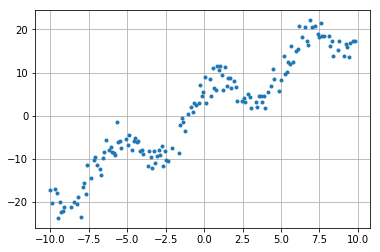

In [4]:
plt.plot(x_train, y_train, '.')

plt.grid()
plt.show()

In [5]:
def map_feature(x):
    return np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T

In [6]:
X_train = map_feature(x_train)
X_test = map_feature(x_test)

In [7]:
w_hat = np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
w_hat

array([1.13720211, 1.97565739, 2.60619016, 4.18098566])

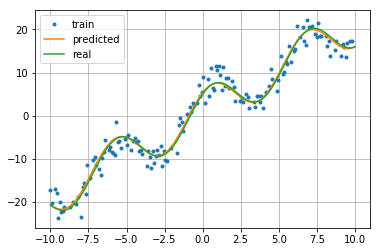

In [8]:
plt.plot(x_train, y_train, '.', label='train')
x = np.linspace(-10, 10, 2000)
plt.plot(x, map_feature(x)@w_hat, label='predicted')

x = np.linspace(-10, 10, 2000)
plt.plot(x, map_feature(x)@w, label='real')

plt.legend(loc='best')
plt.grid()
plt.show()

#### Вариант 2
Ищем решение $\hat{f}$ в пространстве $\mathfrak{F}$. Функция $\hat{f}$ полностью описывается своими параметрами $\hat{w}$.

Как находить вектор параметров $\hat{w}$?

1. Градиентный спуск:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha_t\frac{\partial L}{\partial \mathbf{w}}\bigr(\mathbf{w}_{t}\bigr)
$$
2. Метод Ньютона-Рафсона:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha_t\left(\frac{\partial^2 L}{\partial \mathbf{w} \partial \mathbf{w}^{\mathbf{T}}}\bigr(\mathbf{w}_{t}\bigr)\right)^{-1}\frac{\partial L}{\partial \mathbf{w}}\bigr(\mathbf{w}_{t}\bigr)
$$
3. Метод Ньютона-Гаусса:
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha_t\left(\mathbf{F}_t^{\mathsf{T}}\mathbf{F}_t\right)^{-1}\mathbf{F}_t^{T}\left(\mathbf{f}_t - \mathbf{y}\right), \qquad \mathbf{F}_t = \left\|\frac{\partial f}{\partial w^j}\bigr(x_i, \mathbf{w}_t\bigr)\right\|_{i,j}, \qquad \mathbf{f}_t = \left\|f\bigr(x_i, \mathbf{w}_t\bigr)\right\|_i
$$

In [9]:
def f(w, x):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return X@w

def d_f_d_w(w, x):
    return np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T

def d_L_d_w(w, x, y):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return 2*X.T@X@w-2*X.T@y

def d_2_L_d_2_w(w, x, y):
    X = np.vstack([np.ones_like(x), x, np.sin(x), np.cos(x)]).T
    return 2*X.T@X

##### Градиентный спуск
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha_t\frac{\partial L}{\partial \mathbf{w}}\bigr(\mathbf{w}_{t}\bigr)
$$

In [10]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    w_hat = w_hat - 0.0001*d_L_d_w(w_hat, x_train, y_train)
    list_of_w.append(w_hat)
    
list_of_w = np.array(list_of_w[:500])

CPU times: user 354 ms, sys: 6.72 ms, total: 361 ms
Wall time: 368 ms


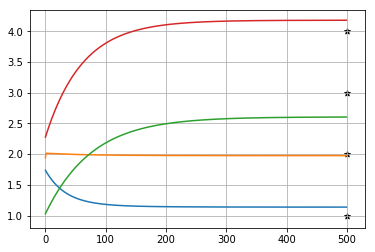

In [11]:
_ = plt.plot(list_of_w)

plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')

plt.grid()

##### Метод Ньютона Рафсона
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha_t\left(\frac{\partial^2 L}{\partial \mathbf{w} \partial \mathbf{w}^{\mathbf{T}}}\bigr(\mathbf{w}_{t}\bigr)\right)^{-1}\frac{\partial L}{\partial \mathbf{w}}\bigr(\mathbf{w}_{t}\bigr)
$$

In [12]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    w_hat = w_hat - np.linalg.inv(d_2_L_d_2_w(w_hat, x_train, y_train))@d_L_d_w(w_hat, x_train, y_train)
    list_of_w.append(w_hat)
    
list_of_w = np.array(list_of_w[:500])

CPU times: user 1.48 s, sys: 112 ms, total: 1.59 s
Wall time: 841 ms


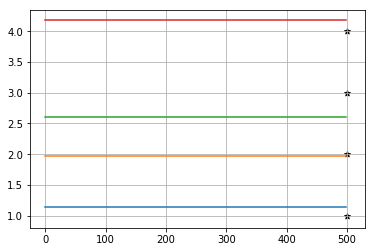

In [13]:
_ = plt.plot(list_of_w)

plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')

plt.grid()

##### Метод Ньютона Гаусса
$$
\mathbf{w}_{t+1} = \mathbf{w}_{t} - \alpha_t\left(\mathbf{F}_t^{\mathsf{T}}\mathbf{F}_t\right)^{-1}\mathbf{F}_t^{T}\left(\mathbf{f}_t - \mathbf{y}\right), \qquad \mathbf{F}_t = \left\|\frac{\partial f}{\partial w^j}\bigr(x_i, \mathbf{w}_t\bigr)\right\|_{i,j}, \qquad \mathbf{f}_t = \left\|f\bigr(x_i, \mathbf{w}_t\bigr)\right\|_i
$$

In [14]:
%%time
np.random.seed(0)
w_hat = np.random.randn(4)

list_of_w = []
for t in range(1, 10000):
    F_t = d_f_d_w(w_hat, x_train)
    w_hat = w_hat-np.linalg.inv(F_t.T@F_t)@F_t.T@(f(w_hat, x_train)- y_train)
    list_of_w.append(w_hat)
    
list_of_w = np.array(list_of_w[:500])

CPU times: user 1.33 s, sys: 103 ms, total: 1.43 s
Wall time: 734 ms


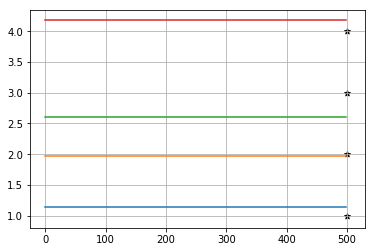

In [15]:
_ = plt.plot(list_of_w)

plt.scatter([len(list_of_w)]*4, w, marker='*', color='black')

plt.grid()

### Задача 2

Пусть задана выборка 
$$
\mathfrak{D} = \{x_i, y_i\}_{i=1}^{l}, \quad x_i \in \mathbb{R}, \quad y_i \in \mathbb{R}.
$$

Известно, что
$$
y_i = f\bigr(x_i\bigr)\quad \forall i \in 1...l,
$$
где функция f принадлежит следующему параметрическом семейству функций $\mathfrak{F}$:
$$
\mathfrak{F} = \left\{f: f\bigr(x, \mathbf{w}\bigr) = \exp\bigr(w_0x\bigr) + w_1\sin\bigr(w_2x\bigr)\right).
$$


Как аппроксимировать выборку $\mathfrak{D}$?

Под апроксимацией выборки подрозумевается минизация следующего функционала:
$$
L = \sum_{i=1}^{l}\left(f\bigr(x_i, \mathbf{w}\bigr) - y_i\right)^{2} \to \min_{\mathbf{w}}
$$

In [16]:
np.random.seed(0)
l = 200
beta = 0.2

x = np.linspace(-2, 2, l)
w = np.array([1., 2., 3.])
y = np.exp(w[0]*x)+ w[1]*np.sin(x*w[2]) + beta*np.random.randn(l)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=50)

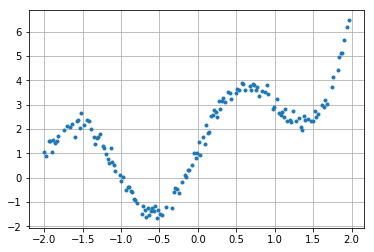

In [17]:
plt.plot(x_train, y_train, '.')

plt.grid()
plt.show()

### Воспользуемся градиентным спуском

In [18]:
def f(x, w):
    return torch.exp(w[0]*x)+ w[1]*torch.sin(x*w[2])

In [19]:
torch.manual_seed(0)
w_hat = torch.randn(3)
w_hat.requires_grad = True

X_tr = torch.FloatTensor(x_train)
y_tr = torch.FloatTensor(y_train)

loss_function = torch.nn.MSELoss()
optim = torch.optim.SGD([w_hat], lr=0.01)

for i in tqdm(range(1, 1000), leave=False):
    optim.zero_grad()

    loss = loss_function(f(X_tr, w_hat),y_tr)
    loss.backward()
    
    optim.step()


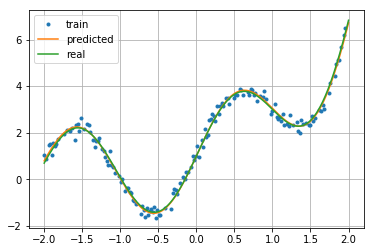

In [20]:
plt.plot(x_train, y_train, '.', label='train')
x = np.linspace(-2, 2, 2000)
plt.plot(x, f(torch.Tensor(x), w_hat).detach().cpu().numpy(), label='predicted')

x = np.linspace(-2, 2, 2000)
plt.plot(x, f(torch.Tensor(x), torch.tensor(w)).detach().cpu().numpy(), label='real')

plt.legend(loc='best')
plt.grid()
plt.show()

Напомню вид семейства функций:
$$
\mathfrak{F} = \left\{f: f\bigr(x, \mathbf{w}\bigr) = \exp\bigr(w_0x\bigr) + w_1\sin\bigr(w_2x\bigr)\right).
$$

В чем недостаток данного семейства?

## Обобщенная линейная модель

Пусть правдоподобие имеет следующий вид:
$$
   p(y|\theta, \phi) = \exp\left(\frac{y\theta- b(\theta)}{a(\phi)} + c\left(y, \phi\right)\right).
$$

Примерами распределений, плотность которых такой вид:
1. Нормальное распределение --- линейная регрессия.
2. Биномиальное распределение --- логистическая регрессия.

### Определение оптимального размера выборки для обобщенно линейно модели

Обобщенно линейные модели используют в прикладной статистике для решения многих задач.

Рассмотри простой пример для определения оптимального размера выборки для задачи линейной регрессии.

Во-первых нужно определеть понятие оптимальности. Во-вторых предложить метод.

Рассмотрим простой пример на основе теста отношения правдоподобий.

Рассмотрим гипотезу:
$$
H_0: \textbf{m}_{u} = \textbf{m}^0_{u}, \quad H_1: \textbf{m}_{u} \not= \textbf{m}^0_{u}.
$$

Определим следующую статистику:
$$
   LR = 2\Big(l\left(\hat{\textbf{w}}\right) - l\left(\hat{\textbf{w}}^0\right)\Big), \quad l\bigr(\mathbf{w}\bigr) = \log L\bigr(\mathbf{w}\bigr)=\sum_{i=1}^{l} \log p\bigr(y_i|x_i, \mathbf{w}\bigr)
$$

Будем говорить, что объем выборки $l$ достаточный, если мы можем проверить нулевую гипотезу на уровне значимости $\alpha$ и ошибке второго рода $\beta$.

Обозначим 
1. Ответ из принципа максимумального правдоподобия $\hat{\textbf{w}} = [\hat{\textbf{w}}_{u},\hat{\textbf{w}}_{v}]$. 
2. Ответ из принципа максимумального правдоподобия $\hat{\textbf{w}}^{0} = [\textbf{m}^{0}_{u},\hat{\textbf{w}}^{0}_{v}],$ при условии фиксируемой части вектора $\textbf{m}^{0}_{u}$.

В случае истинности гипотезы $H_0$ статистика $LR$ ассимптотически имеет распределение $\chi^2(k)$.
В случае истинности гипотезы $H_1$ статистика $LR$ ассимптотически имеет распределение $\chi^2(k,\gamma)$, где $\gamma$ это параметр нецентральности, который выражается в следующем виде:
$$
\gamma = l\Delta^*, \quad \Delta^* = \mathsf{E}\left[2a^{-1}(\phi)\left\{\left(\theta - \theta^*\right)\nabla b(\theta) - b(\theta) + b(\theta^*)\right\}\right],
$$
где параметры $\theta$ и $\theta^*$ считаются при помощи векторов $\textbf{w} = [\textbf{w}_{u}, \textbf{w}_{v}]$ и $\textbf{w}^* = [\textbf{w}^{0}_{u}, \textbf{w}^{*}_{v}]$, причем вектор $\textbf{w}^{*}_{v}$ является решением следующего уравнения:
$$
\lim_{m\to\infty}l^{-1}\mathsf{E}\left(\frac{\partial l\left(\left[\textbf{m}^{0}_{u}, \textbf{w}_{v}\right]\right)}{\partial \textbf{w}_{v}}\right) = 0.
$$

На основе параметров $\alpha$ и $\beta$ оптимальный размер выборки $l^*$ получается с решения уравнения:
$$
l^* = \frac{\gamma^*}{\Delta^*}, \quad \gamma^*:\chi^2_{k, 1-\alpha} = \chi^2_{k, \beta}\left(\gamma\right),
$$
где $\chi^2_{k, 1-\alpha}$, $\chi^2_{k, \beta}\left(\gamma^*\right)$ квантили распределений $\chi^{2}_k$ и $\chi^2_{k}\left(\gamma^*\right)$

-----

Self, S. G., Mauritsen, R. H., & Ohara, J. (1992). Power calculations for likelihood ratio tests in generalized linear models. Biometrics, Vol. 48. P. 31–39

In [21]:
data = dict()

for n in tqdm(range(2, 103, 10), leave=False):
    data[n] = dict()
    for l in range(300, 3000, 100):
        
        np.random.seed(0)
        X_rg = np.random.randn(l, n)
        w = np.random.randn(n)
        y_rg = X_rg@w + np.random.randn(l)*n/20


        model = LikelihoodRatioEstimator(RegressionModel, **{'epsilon': 0.1, 
                                                             'alpha': 0.05, 
                                                             'beta': 0.05})
        ret = model(X_rg, y_rg)
        
        data[n][l] = ret['m*']

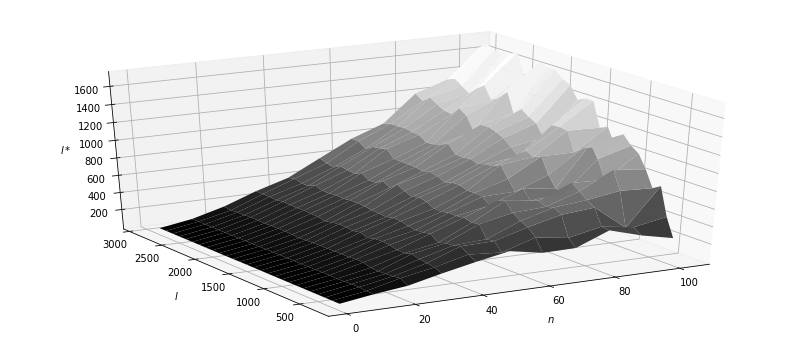

In [22]:
ns, ls = np.meshgrid(list(data.keys()), list(data[2].keys()))
scores = np.zeros_like(ns)
for i in range(len(ns)):
    for j in range(len(ns[i])):
        scores[i][j] = data[ns[i][j]][ls[i][j]]

ax = plt.figure(figsize=(14.0, 6.0)).gca(projection='3d')
ax.plot_surface(ns, ls, scores, cmap='gist_gray', alpha=0.99)
ax.set_xlabel(r'$n$', labelpad= 14), ax.set_ylabel(r'$l$', labelpad=14)
ax.set_zlabel(r'$l*$'), ax.view_init(30, -120)

plt.show()

## Нестандартные функции потерь

### Построение эмбедингов

В качестве простого примера рассматривается задача построения некоторого представления об объектах для их дальнейшего сравнивания. Векторное представление объектов будем называть эмбединг.

Рассмотрим простую задачу построения эмбедингов для предложений.

Пусть задана выборка:
$$
\mathfrak{D} = \left\{s_i, p_i, n_i\right\}_{i=1}^{l},
$$
где $s_i$ это предложение некоторое предложение, множество $p_i$ это множество индексов предложений близких по смыслу к данному, множество $n_i$ это множество индексов предложений далеких от данного.

Требуется построить отображения $f : \mathcal{S} \to \mathbb{R}^{n}$ так чтобы выполнялись следующие условия:
$$
\sum_{i=1}^{l}\sum_{j \in p_i}\left\|f(s_i) - f(s_j)\right\| \to \min
$$
$$
\sum_{i=1}^{l}\sum_{j \in n_i}\left\|f(s_i) - f(s_j)\right\| \to \max
$$

Иногда вместо $\|\cdot\|$ используется косинусное расстояние между векторами, но это сейчас не важно.

Какой функционал качества вы предложите минимизировать?

#### TripletLoss

Самый простой пример, который используют на практике:
$$
L\bigr(f\bigr) = \sum_{i=1}^{l}\max\left\{0, \sum_{j \in p_i}\left\|f(s_i) - f(s_j)\right\| - \sum_{j \in n_i}\left\|f(s_i) - f(s_j)\right\| + \text{margin}\right\} \to \min_{f}.
$$

Если быть точным, то $f$ это некоторая параметрическая функция и настройка парамтеров происходит при помощи градиентных методов.

На каждом шаге генериться батч размера $l'$, который состоит из множества троек $(s_i, \text{positive}_i, \text{negative}_i)$ --- $s_i$ одно предложение из выборки, $\text{positive}_i$ одно предложение похожее на $s_i$, а $\text{negative}_i$ одно предложение не похожее на $s_i$. Тогда на каждом шаге решается задача оптимизации:
$$
L'\bigr(f\bigr) = \sum_{i=1}^{l}\max\left\{0, \left\|f(s_i) - f(\text{positive}_i)\right\| - \left\|f(s_i) - f(\text{negative}_i)\right\| + \text{margin}\right\} \to \min_{f}.
$$

### Задача поиска близких предложений

Обучать модель не будем, а рассмотрим некоторую предобученую модель, которая использует триплетную функцию ошибки.

In [23]:
model = SentenceTransformer('LaBSE')

sentences = ['hello world', 
              'привет мир', 
              'прощайте все', 
              'сегодня лучший день в моей жизни', 
              'сегодня худший день в моей жизни']
vects = model.encode(sentences)
d = cdist(vects, vects)

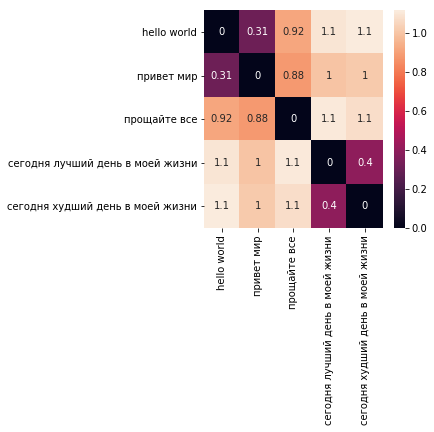

In [24]:
ax = plt.figure(figsize=(4.0, 4.0)).gca()
sns.heatmap(d, xticklabels=sentences, yticklabels=sentences, ax=ax, annot=True)

plt.show()

## ОФФТОП Стохастический градиентный спуск

In [25]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
from torch import nn
from torch import optim

import math

def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])


def jacobian(outputs, inputs, create_graph=False):
    '''
    Compute the Jacobian of `outputs` with respect to `inputs`
    jacobian(x, x)
    jacobian(x * y, [x, y])
    jacobian([x * y, x.sqrt()], [x, y])
    '''
    if torch.is_tensor(outputs):
        outputs = [outputs]
    else:
        outputs = list(outputs)

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    jac = []
    for output in outputs:
        output_flat = output.view(-1)
        output_grad = torch.zeros_like(output_flat)
        for i in range(len(output_flat)):
            output_grad[i] = 1
            jac += [gradient(output_flat, inputs, output_grad, True, create_graph)]
            output_grad[i] = 0
    return torch.stack(jac)

def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

In [26]:
x = np.linspace(7, 20)
y = np.linspace(-1.0, 1.2)

def f(x, y):
    return 0.5*np.sin(x)/((x-6)**2)**0.1+y**2

def f_tensor(x):
    return 0.5*torch.sin(x[0])/((x[0]-6)**2)**0.1+x[1]**2

In [27]:
torch.manual_seed(9)
w = torch.Tensor([12.5, 1.15])
w.requires_grad = True
optim = torch.optim.SGD([w], lr=0.01)

list_of_w = []
list_of_w.append(w.detach().cpu().numpy().copy())


for i in tqdm(range(1, 2501), leave=False):
    optim.zero_grad()
    
    loss = f_tensor(w)
    loss.backward()
    w.grad += 1.5*torch.randn(2)
    
    optim.step()
    
    if i < 100 and i % 10 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    elif i % 100 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    
list_of_w_sgd = np.array(list_of_w)

In [28]:
torch.manual_seed(9)
w = torch.Tensor([12.5, 1.15])
w.requires_grad = True
optim = torch.optim.SGD([w], lr=0.01)

list_of_w = []
list_of_w.append(w.detach().cpu().numpy().copy())


for i in tqdm(range(1, 2501), leave=False):
    optim.zero_grad()
    
    hess = hessian(f_tensor(w), [w])
    optim.zero_grad()
    grad = gradient(f_tensor(w), [w])
    optim.zero_grad()
    
    w.grad = torch.inverse(hess)@grad
    
    optim.step()
    
    if i < 100 and i % 10 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    elif i % 100 == 0:
        list_of_w.append(w.detach().cpu().numpy().copy())
    
list_of_w_neuton = np.array(list_of_w)

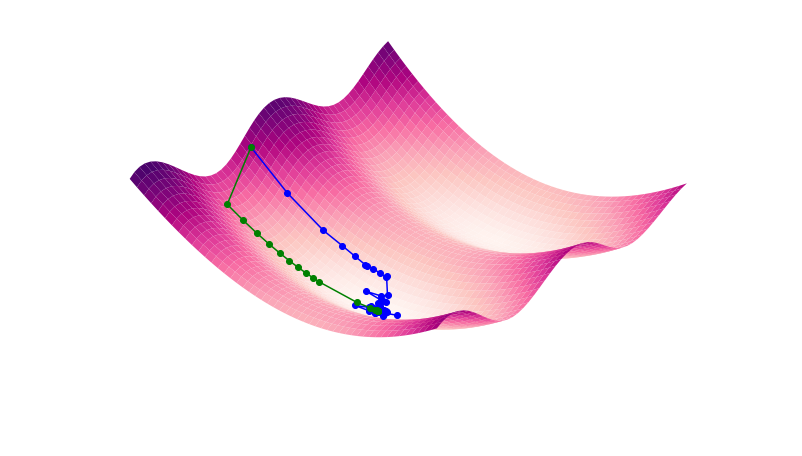

In [29]:
X, Y = np.meshgrid(x, y)
scores = f(X, Y)

ax = plt.figure(figsize=(14.0, 8.0)).gca(projection='3d')

ax.plot_surface(X, Y, scores, cmap='RdPu', alpha=0.99)
ax.plot(list_of_w_sgd[:,0], list_of_w_sgd[:,1], 
        f(list_of_w_sgd[:,0], list_of_w_sgd[:,1]), '-ob')
ax.plot(list_of_w_neuton[:,0], list_of_w_neuton[:,1], 
        f(list_of_w_neuton[:,0], list_of_w_neuton[:,1]), '-og')

ax.view_init(60, -140)

plt.axis('off')
plt.show()